In [1]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [59]:
# pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [104]:
results_dir = './data/outputs'

name_map = {
    # 'llama_2_7b_hf_mono_merged': 'mono (en)',
    'llama_2_7b_hf_ml1_merged': 'Llama-2 Mono',
    'llama_2_7b_hf_ml2_merged': 'Llama-2 ML2',
    'llama_2_7b_hf_ml3_merged': 'Llama-2 ML3',
    'llama_2_7b_hf_ml4_merged': 'Llama-2 ML4',
    'llama_2_7b_hf_ml5_merged': 'Llama-2 ML5',
    # 'llama_2_7b_hf_en_merged': 'ML6/en',
    'llama_2_7b_hf_de_merged': 'Llama-2 ML6/de',
    'llama_2_7b_hf_fr_merged': 'Llama-2 ML6/fr',
    'llama_2_7b_hf_zh_merged': 'Llama-2 ML6/zh',
    'llama_2_7b_hf_es_merged': 'Llama-2 ML6/es',
    'llama_2_7b_hf_ru_merged': 'Llama-2 ML6/ru',
    'llama_2_7b_hf_ca_merged': 'Llama-2 ML6/ca',
    'falcon_7b_de_merged': 'Falcon ML6/de',
    'falcon_7b_zh_merged': 'Falcon ML6/zh',
    'falcon_7b_ru_merged': 'Falcon ML6/ru',
    'falcon_7b_ca_merged': 'Falcon ML6/ca',
    'llama_2_7b_hf_mt_de_merged': 'Llama-2 MT ML6/de', # translated training data
    'llama_2_7b_hf_mt_zh_merged': 'Llama-2 MT ML6/zh', # translated training data
    'llama_2_7b_hf_mt_ru_merged': 'Llama-2 MT ML6/ru', # translated training data
    'llama_2_7b_hf_mt_es_merged': 'Llama-2 MT ML6/es', # translated training data
    'llama_2_7b_hf_mt_ml2_merged': 'Llama-2 MT ML2', # translated training data
    'llama_2_7b_hf_mt_ml3_merged': 'Llama-2 MT ML3', # translated training data
    'llama_2_7b_hf_mt_ml4_merged': 'Llama-2 MT ML4', # translated training data
    'llama_2_7b_hf_mt_ml5_merged': 'Llama-2 MT ML5', # translated training data
    'llama_2_7b_hf_mt_ml6_merged': 'Llama-2 MT ML6', # translated training data
    'llama_2_70b_hf_mt_ml1_merged': 'Llama-2 70B Mono', 
    'llama_2_70b_hf_mt_ml2_merged': 'Llama-2 70B MT ML2', # translated training data
    'llama_2_70b_hf_mt_ml3_merged': 'Llama-2 70B MT ML3', # translated training data
    'llama_2_70b_hf_mt_ml4_merged': 'Llama-2 70B MT ML4', # translated training data
    'llama_2_70b_hf_mt_ml5_merged': 'Llama-2 70B MT ML5', # translated training data
    'llama_2_70b_hf_mt_ml6_merged': 'Llama-2 70B MT ML6', # translated training data
    'alpaca_eval_instructions_en': 'en',
    'alpaca_eval_instructions_de': 'de',
    'alpaca_eval_instructions_fr': 'fr',
    'alpaca_eval_instructions_sv': 'sv',
    'alpaca_eval_instructions_zh': 'zh',
    'alpaca_eval_instructions_es': 'es',
    'alpaca_eval_instructions_ru': 'ru',
    'alpaca_eval_instructions_ca': 'ca',
    'alpaca_eval_instructions_bg': 'bg',
    'alpaca_eval_instructions_no': 'no',
    'alpaca_eval_instructions_da': 'da',
    'alpaca_eval_instructions_is': 'is',
    'alpaca_eval_instructions_hi': 'hi',
    'alpaca_eval_instructions_el': 'el',
}

def load_json(file):
    with open(file, "r", encoding='utf8') as f:
        return json.load(f)

def parse_filename(file):
    """
    data/outputs/llama_2_7b_hf_en_merged/alpaca_eval_instructions_ru-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.eval
    """
    # get test set and context, allowing for no context
    model_name = Path(file).parent.name
    parts = Path(file).stem.split('-')

    test_set = parts[0]
    context = parts[1]
    prompt = parts[2]
    seed = int(parts[3][1:])
    top_k = int(parts[4][1:])
    top_p = float(parts[5][1:])
    temp = float(parts[6][1:])
    bs = int(parts[7][1:])

    has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = None, None, None, None, None, None
    if len(parts) > 8:

        # with_en-l300-ds42-as42-source_en-system_en
        has_translation = parts[8] == 'with_en'
        n_eval_items = int(parts[-5][1:])
        data_seed = int(parts[-4][2:])
        api_seed = int(parts[-3][2:])
        eval_src = parts[-2]
        eval_tgt = parts[-1]

    return model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt


def get_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for eval_file in Path(results_dir).glob('*/*.eval'):
        # print(eval_file)
        df = pd.read_csv(eval_file, index_col=None)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(eval_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
        # # get generation args too
        # try:
        #     hp_file = eval_file.with_suffix(".json")
        #     hps = load_json(hp_file)
        #     eval_dict.update(hps)
        # except:
        #     pass
    
    df = pd.concat(dfs, axis=0, ignore_index=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    df = df.reindex(columns=cols)

    return df

df = get_results(results_dir)
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)
print(len(df))
print(df.columns)
df.head()

1260
Index(['model_name', 'test_set', 'seed', 'lang_match', 'tgt_lang', 'ppl',
       'file', 'context', 'ppl_model', 'n'],
      dtype='object')


,model_name,test_set,seed,lang_match,tgt_lang,ppl,file,context,ppl_model,n
0,Llama-2 Mono,de,0,0.391,0.390,24.971,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
1,Llama-2 Mono,de,42,0.416,0.419,22.476,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
2,Llama-2 Mono,de,723,0.411,0.412,22.836,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s723-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
3,Llama-2 Mono,en,0,0.944,0.964,14.927,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
4,Llama-2 Mono,en,42,0.933,0.954,20673.208,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN


In [105]:
# sort models given the order in name_map
model_names = df['model_name'].unique()
ordered_model_names = sorted(model_names, key=lambda x: list(name_map.values()).index(x))
print(ordered_model_names)
test_sets = df['test_set'].unique()
ordered_test_sets = sorted(test_sets, key=lambda x: list(name_map.values()).index(x))
print(ordered_test_sets)
ordered_seeds = sorted(df['seed'].unique())
print(ordered_seeds)

def apply_sort(df):

    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df['test_set'] = pd.Categorical(df['test_set'], ordered_test_sets)

    if 'seed' in df.columns:
        df = df.sort_values(by=['model_name', 'test_set', 'seed'])
    else:
        df = df.sort_values(by=['model_name', 'test_set'])

    # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    df['test_set'] = df['test_set'].astype(str)
        
    df = df.reset_index(drop=True)

    return df

# drop columns containing any NaN values
# df = df.dropna(axis=1, how='any')

# sort dataframe
df = apply_sort(df)
# store sort order
# custom_sort_index = df.index.tolist()
# df['idx'] = custom_sort_index
# print(df.columns)
df.head(40)

['Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/de', 'Llama-2 ML6/fr', 'Llama-2 ML6/zh', 'Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/ca', 'Falcon ML6/de', 'Falcon ML6/zh', 'Falcon ML6/ru', 'Falcon ML6/ca', 'Llama-2 MT ML6/de', 'Llama-2 MT ML6/zh', 'Llama-2 MT ML6/ru', 'Llama-2 MT ML6/es', 'Llama-2 MT ML2', 'Llama-2 MT ML3', 'Llama-2 MT ML4', 'Llama-2 MT ML5', 'Llama-2 MT ML6', 'Llama-2 70B Mono', 'Llama-2 70B MT ML2', 'Llama-2 70B MT ML3', 'Llama-2 70B MT ML4', 'Llama-2 70B MT ML5', 'Llama-2 70B MT ML6']
['en', 'de', 'fr', 'sv', 'zh', 'es', 'ru', 'ca', 'bg', 'no', 'da', 'is', 'hi', 'el']
[0, 42, 723]


,model_name,test_set,seed,lang_match,tgt_lang,ppl,file,context,ppl_model,n
0,Llama-2 Mono,en,0,0.944,0.964,14.927,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
1,Llama-2 Mono,en,42,0.933,0.954,20673.208,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
2,Llama-2 Mono,en,723,0.938,0.960,18.525,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s723-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
3,Llama-2 Mono,de,0,0.391,0.390,24.971,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
4,Llama-2 Mono,de,42,0.416,0.419,22.476,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
35,Llama-2 Mono,is,723,0.273,0.273,59.993,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_is-none-guanaco_prompt-s723-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
36,Llama-2 Mono,hi,0,0.206,0.210,17.020,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_hi-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
37,Llama-2 Mono,hi,42,0.214,0.224,31.689,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_hi-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
38,Llama-2 Mono,hi,723,0.216,0.220,13.207,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_hi-none-guanaco_prompt-s723-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN


In [106]:
def get_results_overview(df, cols=['model_name', 'test_set', 'seed']):
    for col in cols:
        print(f'*** {col} ***')
        print(df[col].value_counts())
        print()

get_results_overview(df)

*** model_name ***
Llama-2 Mono          42
Llama-2 ML2           42
Llama-2 70B MT ML5    42
Llama-2 70B MT ML4    42
Llama-2 70B MT ML3    42
                      ..
Llama-2 ML6/de        42
Llama-2 ML5           42
Llama-2 ML4           42
Llama-2 ML3           42
Llama-2 70B MT ML6    42
Name: model_name, Length: 30, dtype: int64

*** test_set ***
en    90
de    90
fr    90
sv    90
zh    90
      ..
no    90
da    90
is    90
hi    90
el    90
Name: test_set, Length: 14, dtype: int64

*** seed ***
0      420
42     420
723    420
Name: seed, dtype: int64



In [107]:
def get_agg_df(
        df, 
        group_cols=['model_name', 'test_set'], 
        agg_ops={
            'lang_match': [np.mean, np.std], 
            'tgt_lang': [np.mean, np.std], 
            'ppl': [np.mean, np.std],
            }
        ):
    """
    Aggregates the results of the different strategies.
    If use_macro is True, then the macro-averaged results are used, otherwise the micro-averaged results are used.
    """
    df = df.groupby(group_cols, as_index=True).agg(agg_ops)
    # df = df.reindex(['0-shot', '1-shot', 'Mem-4', 'Mem-8', 'L2M'])
    # df[df.select_dtypes(include=['number']).columns] *= 100
    df = df.round(2)
    return df

def styled_df(df, color):
    return df.style.background_gradient(axis=0, text_color_threshold=0, cmap=sns.light_palette(color, as_cmap=True)).highlight_max(axis=0, props='font-weight:bold;').format(precision=2)

# unset multi-index
agg_df = get_agg_df(df).reset_index()
# join levels of multi-index columns
agg_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in agg_df.columns]
styled_df(agg_df, 'seagreen')

,model_name_,test_set_,lang_match_mean,lang_match_std,tgt_lang_mean,tgt_lang_std,ppl_mean,ppl_std
0,Falcon ML6/ca,bg,0.49,0.01,0.00,0.00,75.26,16.64
1,Falcon ML6/ca,ca,0.19,0.02,0.19,0.02,51.90,7.98
2,Falcon ML6/ca,da,0.70,0.01,0.00,0.00,35.22,5.74
3,Falcon ML6/ca,de,0.95,0.01,0.96,0.01,34.11,11.96
4,Falcon ML6/ca,el,0.96,0.01,0.96,0.01,39128.05,67668.74
5,Falcon ML6/ca,en,0.94,0.00,0.97,0.00,31.61,5.71
6,Falcon ML6/ca,es,0.93,0.00,0.96,0.00,190.71,226.24
7,Falcon ML6/ca,fr,0.96,0.00,0.96,0.01,13824.15,11885.24
8,Falcon ML6/ca,hi,0.44,0.02,0.46,0.02,12.86,0.65
9,Falcon ML6/ca,is,0.88,0.02,0.89,0.02,258.55,100.45


data/plots/llama2_7b_lang_match_incremental_ml.png saved.


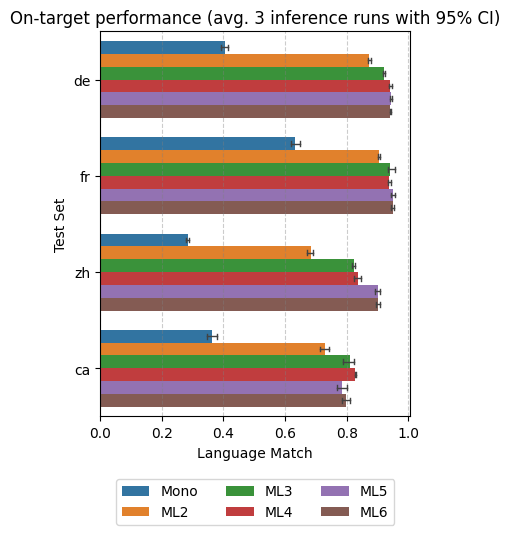

In [108]:

# plot bar plots of lang_match

def make_basic_barplot(df, title=None, save_path=None):
    fig, ax = plt.subplots(figsize=(4, 5))

    sns.barplot(data=df,
                x='lang_match', y='test_set', 
                hue='model_name', 
                errorbar=("ci", 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                # errorbar='ci', capsize=0.002,
                orient='h',
                ax=ax)

    if title:
        ax.set_title(title)

    ax.set_xlabel('Language Match')
    ax.set_ylabel('Test Set')

    # add vertical gridlines
    ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.4)

    # legend at bottom
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

# make_basic_barplot(df, title=None, save_path=None)

# get only Llama-2 models with incremental multilingual training
# en, es, ru, de, zh, fr, ca
sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 ML2', 'Llama-2 ML3', 'Llama-2 ML4', 'Llama-2 ML5', 'Llama-2 ML6/ca'])]
sdf = sdf[sdf['test_set'].isin(['de', 'fr', 'zh', 'ca'])]
# sdf = sdf[sdf['test_set'].isin(['sv', 'da', 'no', 'is', 'bg'])]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')
make_basic_barplot(
    sdf, 
    title='On-target performance (avg. 3 inference runs with 95% CI)', 
    save_path='data/plots/llama2_7b_lang_match_incremental_ml.png')

data/plots/llama2_7b_lang_match_incremental_mt_ml.png saved.


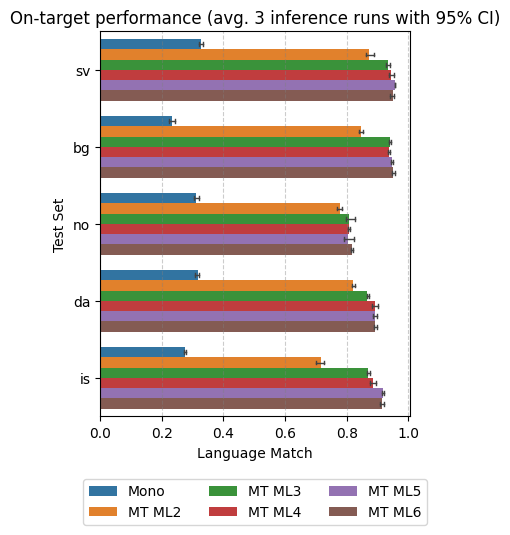

In [109]:
# get only Llama-2 models with incremental MT multilingual training
# en, es, ru, de, zh, fr, ca
sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT ML2', 'Llama-2 MT ML3', 'Llama-2 MT ML4', 'Llama-2 MT ML5', 'Llama-2 MT ML6'])]
# sdf = sdf[sdf['test_set'].isin(['de', 'fr', 'zh', 'ca'])]
sdf = sdf[sdf['test_set'].isin(['sv', 'da', 'no', 'is', 'bg'])]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')
make_basic_barplot(
    sdf, 
    title='On-target performance (avg. 3 inference runs with 95% CI)', 
    save_path='data/plots/llama2_7b_lang_match_incremental_mt_ml.png')

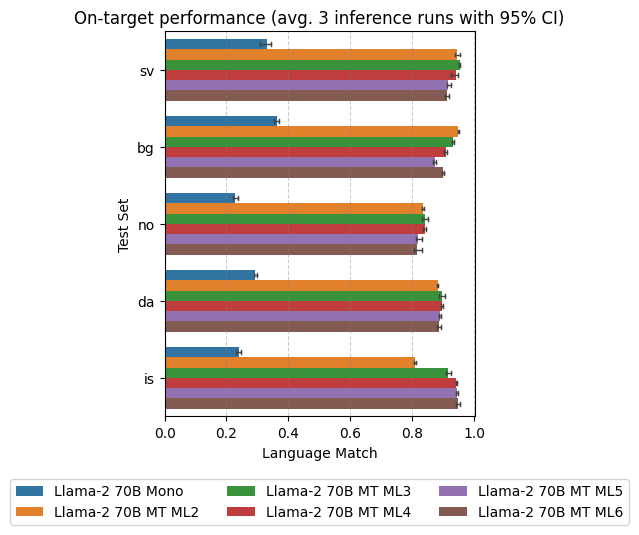

In [110]:
# get only Llama-2 models with incremental multilingual training
# en, es, ru, de, zh, fr
sdf = df[df['model_name'].isin(
    ['Llama-2 70B Mono', 'Llama-2 70B MT ML2', 
     'Llama-2 70B MT ML3', 'Llama-2 70B MT ML4',
     'Llama-2 70B MT ML5', 'Llama-2 70B MT ML6',
     ])]
# sdf = sdf[sdf['test_set'].isin(['de', 'fr', 'zh', 'ru',])]
sdf = sdf[sdf['test_set'].isin(['sv', 'da', 'no', 'is', 'bg'])]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')
make_basic_barplot(
    sdf, 
    title='On-target performance (avg. 3 inference runs with 95% CI)', 
    # save_path='data/plots/llama2_70b_lang_match_incremental_ml.png'
    )

/tmp/ipykernel_2295684/3666748217.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')


data/plots/llama2_7b_lang_match_loo.png saved.


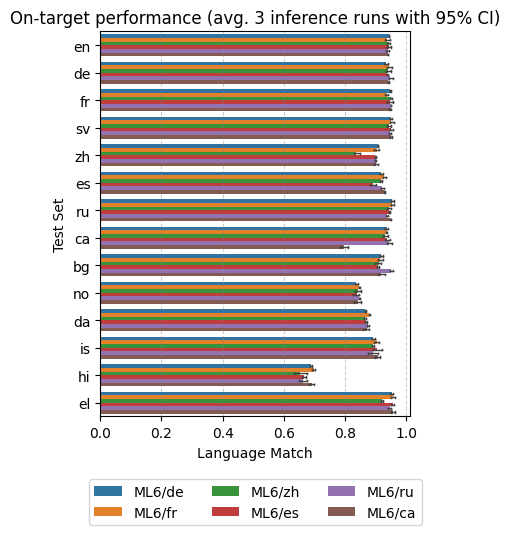

In [111]:
# get only Llama-2 models with incremental multilingual training
# en, es, ru, de, zh, fr
sdf = df[df['model_name'].isin(['Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/de', 'Llama-2 ML6/zh', 'Llama-2 ML6/fr', 'Llama-2 ML6/ca'])]
# sdf = sdf[sdf['test_set'].isin(['en', 'de', 'fr', 'zh', 'ru',])]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')
make_basic_barplot(
    sdf, 
    title='On-target performance (avg. 3 inference runs with 95% CI)', 
    save_path='data/plots/llama2_7b_lang_match_loo.png')

data/plots/llama2_7b_lang_match_loo_heatmap.png saved.


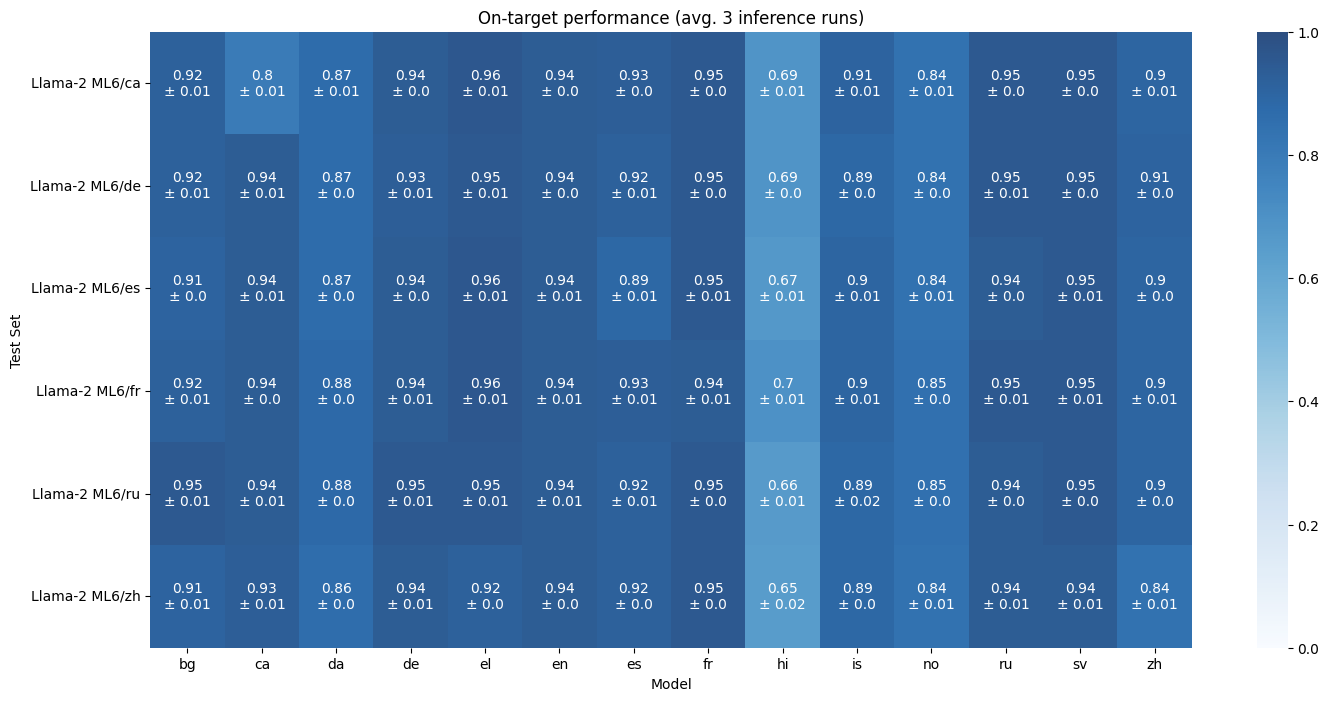

In [112]:
def make_basic_heatmap(df, metric, include_std=False, title=None, save_path=None):
        
    fig, ax = plt.subplots(figsize=(df.shape[0]*0.2, df.shape[1]))
    
    heatmap_mean = df.pivot_table(index='model_name', columns='test_set', values=f'{metric}_mean', sort=False)
    heatmap_std = df.pivot_table(index='model_name', columns='test_set', values=f'{metric}_std', sort=False)

    if include_std:
        annotations = heatmap_mean.round(2).astype(str) + "\n± " + heatmap_std.round(2).astype(str)
    else:
        annotations = heatmap_std.round(2).astype(str)

    ax = sns.heatmap(
        heatmap_mean, annot=annotations, fmt='', 
        cmap="Blues", alpha=0.85, cbar=True, 
        cbar_kws=None, 
        vmin=0, vmax=1.0, ax=ax
        )

    # sns.heatmap(heatmap_subset_mean, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax)
    # sns.heatmap(heatmap_subset_std, annot=True, fmt='.2f', cmap='Reds', cbar=False, ax=ax)
    
    if title:
        ax.set_title(title)

    ax.set_xlabel('Model')
    ax.set_ylabel('Test Set')

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

sdf = df[df['model_name'].isin(['Llama-2 ML6/es', 'Llama-2 ML6/ru', 'Llama-2 ML6/de', 'Llama-2 ML6/zh', 'Llama-2 ML6/fr', 'Llama-2 ML6/ca'])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]
# agg_sdf.pivot_table(index='model_name', columns='test_set', values=f'lang_match_mean')

# # pivot
make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='On-target performance (avg. 3 inference runs)', 
    save_path='data/plots/llama2_7b_lang_match_loo_heatmap.png')


In [113]:
# process lm-eval harness results

def load_lm_eval_results_file(file):
    with open(file, "r", encoding='utf8') as f:
        df = pd.DataFrame.from_dict(json.load(f)['results'])
        df['model_name'] = Path(file).stem
        return df

def get_lm_eval_results(results_dir):
    dfs = []
    for results_file in Path(results_dir).glob('*.json'):
        print(results_file)
        df = load_lm_eval_results_file(results_file)
        dfs.append(df)
    df = pd.concat(dfs, axis=0, ignore_index=False).reset_index()
    df = df.rename(columns={'index': 'metric'})

    # Reshape the dataframe, moving model_name and index to the index
    df_long = pd.melt(df, id_vars=['model_name', 'metric'], var_name='task_lang', value_name='score')

    # Split the task_lang into two separate columns for 'task' and 'lang'
    df_long[['task', 'lang']] = df_long['task_lang'].str.split('_', expand=True)

    # Drop the original task_lang column as it's no longer needed
    df_long.drop('task_lang', axis=1, inplace=True)

    # Now pivot to get the 'task', 'lang' and 'index' as part of the column MultiIndex
    df = df_long.pivot_table(index='model_name', columns=['task', 'lang', 'metric'], values='score')

    # # move model_name to front
    # cols = df.columns.tolist()
    # cols.insert(0, cols.pop(cols.index('model_name')))
    # df = df.reindex(columns=cols)
    
    # # split task and lang tags into multiple levels

    # df.set_index(['model_name', 'metric'], inplace=True)
    # df = df.unstack(level='metric')
    
    df.info()

    return df

df = get_lm_eval_results('data/lm_evals')
# df = load_lm_eval_results_file('data/lm_evals/llama_2_7b_hf_ca_merged.json')
# print(df.iloc[:6, :5].to_csv(float_format='%.2f'))
# df = load_lm_eval_results_file('data/lm_evals/llama_2_7b_hf_ca_merged.json')

# styled dataframe
# def styled_df(df, color='seagreen'):
#     # combine acc_stderr with acc values += ±
#     # stdf = stdf.apply(lambda x: x.str.replace('±', '± '))
#     return df.style.background_gradient(axis=0, text_color_threshold=0, cmap=sns.light_palette(color, as_cmap=True)).highlight_max(axis=0, props='font-weight:bold;').format(precision=2)

# styled_df(df['pawsx'])

print(df['pawsx'].to_csv(float_format='%.2f'))


data/lm_evals/llama_2_7b_hf_zh_merged.json
data/lm_evals/llama_2_7b_hf_de_merged.json
data/lm_evals/llama_2_7b_hf_fr_merged.json
data/lm_evals/llama_2_7b_hf_es_merged.json
data/lm_evals/llama_2_7b_hf_ca_merged.json
data/lm_evals/llama_2_7b_hf_ru_merged.json
<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, llama_2_7b_hf_ca_merged to llama_2_7b_hf_zh_merged
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   (pawsx, de, acc)             6 non-null      float64
 1   (pawsx, de, acc_stderr)      6 non-null      float64
 2   (pawsx, en, acc)             6 non-null      float64
 3   (pawsx, en, acc_stderr)      6 non-null      float64
 4   (pawsx, es, acc)             6 non-null      float64
 5   (pawsx, es, acc_stderr)      6 non-null      float64
 6   (pawsx, fr, acc)             6 non-null      float64
 7   (pawsx, fr, acc_stderr)      6 non-null      float64
 8   (pawsx, ja, acc) 

In [114]:
# get list of level 0 columns
def process_single_dataset_df(df):

    # Remove the header row with metric information and the row with model names
    df = df.drop(index=[0, 1]).reset_index(drop=True)

    # Combine 'acc' and 'acc_stderr' into a single string column 'mean ± std' for each language
    for lang in ['de', 'en', 'es', 'fr', 'ja', 'ko', 'zh']:
        acc_col = lang
        stderr_col = lang + '.1'
        df[lang] = df[acc_col].astype(str) + ' ± ' + df[stderr_col].astype(str)

    # Drop the now unnecessary 'stderr' columns
    df = df.drop(columns=[col for col in df if col.endswith('.1')])

    # Convert accuracy columns to numeric for gradient and bold formatting
    numeric_df = df.copy()
    for col in numeric_df.columns:
        if col != 'lang':
            numeric_df[col] = numeric_df[col].apply(lambda x: float(x.split(' ± ')[0]))

    # Apply the gradient shading based on the mean values
    styled_df = numeric_df.style.apply(lambda x: ["font-weight: bold" if v == max(x) else "" for v in x], axis=0, subset=numeric_df.columns[1:])\
                                .background_gradient(subset=pd.IndexSlice[:, numeric_df.columns[1:]], cmap='viridis', high=0.5, low=0)

    # Return the styled dataframe with combined 'mean ± std' values
    styled_df

    # df = df.drop([0, 1]).reset_index(drop=True)
#     level_0_cols = df.columns.get_level_values(0).unique().tolist()
#     print(level_0_cols)

# # # Combine 'acc' and 'acc_stderr' for each language into a single column
#     for lang in level_0_cols:
#         print(df[lang].astype(float).map('{:.2f}'.format))
#         # df[lang] = df[lang].astype(float).map('{:.2f}'.format) + ' ± ' + df[lang+'.1'].astype(float).map('{:.2f}'.format)

    # return df
# # Convert accuracy to numeric for gradient and bold styling
# for lang in ['de', 'en', 'es', 'fr', 'ja', 'ko', 'zh']:
#     df_cleaned[lang] = df_cleaned[lang].astype(float)

# # Apply the styling
# styled_df = combined_df.style.apply(lambda x: ["font-weight: bold" if v == x.max() else "" for v in x], axis=0)\
#                              .background_gradient(cmap='viridis', subset=pd.IndexSlice[:, ['de', 'en', 'es', 'fr', 'ja', 'ko', 'zh']])
# styled_df

# # Function to extract numeric values from the 'mean ± std' format
# def extract_mean(value):
#     return float(value.split('±')[0].strip())

# # Apply this function to each column to get a DataFrame with numeric means for gradient shading
# mean_values_df = combined_df.set_index('lang').applymap(extract_mean)

# # Now we find the highest mean values for each column
# max_means = mean_values_df.max()

# # Bold the highest means in the combined DataFrame
# for lang in combined_df.columns[1:]:  # Skip the first 'lang' column
#     combined_df[lang] = combined_df[lang].apply(lambda x: f"**{x}**" if extract_mean(x) == max_means[lang] else x)

# # Apply gradient shading to the DataFrame with numeric means
# # We use the mean_values_df for gradient but display the styled combined_df
# styled_df = combined_df.style.apply(lambda x: ["font-weight: bold" if "**" in v else "" for v in x], axis=0)\
#                              .background_gradient(cmap='viridis', subset=pd.IndexSlice[:, ['de', 'en', 'es', 'fr', 'ja', 'ko', 'zh']], vmin=mean_values_df.min().min(), vmax=mean_values_df.max().max())

# styled_df
# process_single_dataset_df(df['pawsx'])
df['pawsx'].index

Index(['llama_2_7b_hf_ca_merged', 'llama_2_7b_hf_de_merged',
       'llama_2_7b_hf_es_merged', 'llama_2_7b_hf_fr_merged',
       'llama_2_7b_hf_ru_merged', 'llama_2_7b_hf_zh_merged'],
      dtype='object', name='model_name')

In [123]:
# llm judge results


def get_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for llm_eval_file in sorted(Path(results_dir).glob('*/*.jsonl')):
        print(llm_eval_file)
        df = pd.read_json(llm_eval_file, lines=True)

        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(llm_eval_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        df['has_translation'] = has_translation
        df['n_eval_items'] = n_eval_items
        df['data_seed'] = data_seed
        df['api_seed'] = api_seed
        df['eval_src'] = eval_src
        df['eval_tgt'] = eval_tgt

        dfs.append(df)
        
        # # get generation args too
        # try:
        #     hp_file = eval_file.with_suffix(".json")
        #     hps = load_json(hp_file)
        #     eval_dict.update(hps)
        # except:
        #     pass
    
    df = pd.concat(dfs, axis=0, ignore_index=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('eval_src')))
    cols.insert(4, cols.pop(cols.index('eval_tgt')))
    df = df.reindex(columns=cols)

    return df

df = get_results('data/llm_evals/likert/gpt-3.5-turbo-1106')

# inspect rows with NaN values in eval_score
# df[df['eval_score'].isna()]
# df[df['eval_score'] == 0]

# drop rows containing isna values in eval_score
df = df.dropna(subset=['eval_score'])

# drop rows where eval_score is not between 1 and 6
df = df[(df['eval_score'] >= 1) & (df['eval_score'] <= 6)]

# if 'system_lang' does not match 'source_lang', then set 'eval_score' to 1
df.loc[df['system_lang'] != df['source_lang'], 'eval_score'] = 1

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

df.info()

data/llm_evals/likert/gpt-3.5-turbo-1106/llama_2_7b_hf_ca_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8-with_en-l300-ds42-as42-source-system.jsonl
data/llm_evals/likert/gpt-3.5-turbo-1106/llama_2_7b_hf_ca_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8-with_en-l300-ds42-as42-source_en-system_en.jsonl
data/llm_evals/likert/gpt-3.5-turbo-1106/llama_2_7b_hf_ca_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8-with_en-l300-ds42-as42-source-system.jsonl
data/llm_evals/likert/gpt-3.5-turbo-1106/llama_2_7b_hf_ca_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8-with_en-l300-ds42-as42-source_en-system_en.jsonl
data/llm_evals/likert/gpt-3.5-turbo-1106/llama_2_7b_hf_ca_merged/alpaca_eval_instructions_de-none-guanaco_prompt-s723-k50-p0.9-t0.8-b8-with_en-l300-ds42-as42-source-system.jsonl
data/llm_evals/likert/gpt-3.5-turbo-1106/llama_2_7b_hf_ca_merged/alpaca_eval_instructions_de-none-guanac

In [124]:
print(df['eval_src'].value_counts())
print(df['eval_tgt'].value_counts())
print(df['eval_score'].value_counts())
print(df['test_set'].value_counts())

source       4492
source_en    3596
Name: eval_src, dtype: int64
system       4492
system_en    3596
Name: eval_tgt, dtype: int64
4.0    2001
1.0    1641
5.0    1356
3.0    1276
2.0    1054
6.0     760
Name: eval_score, dtype: int64
de    3597
ru    3593
en     898
Name: test_set, dtype: int64


In [125]:
# inspect total tokens from eval_meta
eval_costs = []
for i, row in df.iterrows():
    # eval_tokens.append(row['eval_meta']['prompt_tokens'] + row['eval_meta']['completion_tokens'])
    cost = row['eval_meta']['cost']
    if isinstance(row['translation_meta'], dict):
        cost += row['translation_meta']['cost']
    eval_costs.append(cost)

print(len(eval_costs))
print(np.mean(eval_costs))
print(max(eval_costs))
print(min(eval_costs))
print(sum(eval_costs))

8088
0.0016467438180016317
0.014398999999999999
0.000598
13.31886399999715


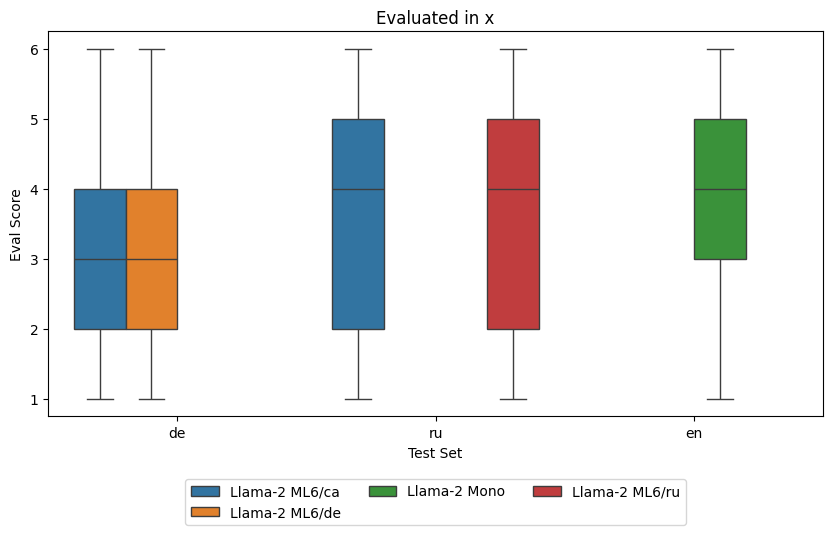

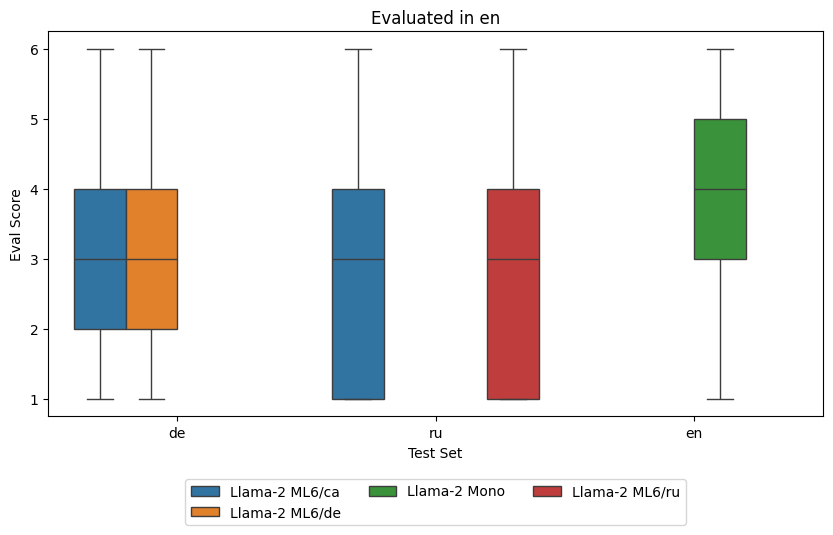

In [126]:

def plot_score_distribution(df, title=None, save_path=None):

# for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    ax.set_xlabel('Test Set')
    ax.set_ylabel('Eval Score')
    
    ax.set_title(title)

    # place legend outside of plot at bottom with 3 columns
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

plot_score_distribution(df[ (df['eval_src'] == 'source') & (df['eval_tgt'] == 'system') ], title='Evaluated in x')

plot_score_distribution(df[ ((df['eval_src'] == 'source_en') & (df['eval_tgt'] == 'system_en')) | (df['test_set'] == 'en') ], title='Evaluated in en')


In [82]:
def get_generations(results_dir):
    dfs = []
    for generations_file in Path(results_dir).glob('*/*.llm_eval'):
        # print(eval_file)
        df = pd.read_json(generations_file, lines=True)
        model_name, test_set, prompt, seed = parse_filename(generations_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
    df = pd.concat(dfs, axis=0, ignore_index=False)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    # cols.insert(0, df.ndex)
    df = df.reindex(columns=cols)

    return df

gen_df = get_generations(results_dir)

gen_df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)
print(len(gen_df))
print(gen_df.columns)
gen_df.head()

# data/outputs/llama_2_7b_hf_zh_merged/alpaca_eval_instructions_zh-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8-gpt_3.5_turbo-l50.llm_eval

3750
Index(['model_name', 'test_set', 'seed', 'prompt', 'system', 'finish_reason',
       'source', 'secs', 'source_lang', 'system_lang', 'id',
       'gpt-3.5-turbo-judgement', 'gpt-3.5-turbo-justification',
       'gpt-3.5-turbo-cost', 'context', 'gpt-4-judgement',
       'gpt-4-justification', 'gpt-4-cost'],
      dtype='object')


,model_name,test_set,seed,prompt,system,finish_reason,source,secs,source_lang,system_lang,id,gpt-3.5-turbo-judgement,gpt-3.5-turbo-justification,gpt-3.5-turbo-cost,context,gpt-4-judgement,gpt-4-justification,gpt-4-cost
0,Llama-2 ML6/de,de,42,"### Human: ""Warum fühlt man sich durch Wärme m...",Die Frage nach dem Verständnis der psychologis...,stop,"""Warum fühlt man sich durch Wärme müde?""",1.623084,deu_Latn,deu_Latn,193,Excellent,"informative, interesting",0.001520,guanaco_prompt,NaN,NaN,NaN
1,Llama-2 ML6/de,de,42,"### Human: ""Erklären Sie, was das unterstriche...","Für Kinder ist das unterstrichene Wort ""ein Ve...",stop,"""Erklären Sie, was das unterstrichene Wort für...",0.935782,deu_Latn,deu_Latn,719,Excellent,"informative, interesting",0.001094,guanaco_prompt,NaN,NaN,NaN
2,Llama-2 ML6/de,de,42,"### Human: ""Eins Eins war ein Rennpferd. Zwei ...","In dieser Geschichte gibt es zwei Pferde, ein ...",stop,"""Eins Eins war ein Rennpferd. Zwei Zwei war au...",1.396412,deu_Latn,deu_Latn,169,Excellent,"informative, interesting",0.000906,guanaco_prompt,NaN,NaN,NaN
3,Llama-2 ML6/de,de,42,"### Human: ""Dir wird eine Beschreibung gegeben...",Als Reaktion auf die geplante russische Invasi...,stop,"""Dir wird eine Beschreibung gegeben, die eine ...",1.525187,deu_Latn,deu_Latn,523,Fail,language,0.001013,guanaco_prompt,NaN,NaN,NaN
4,Llama-2 ML6/de,de,42,"### Human: ""Dir wird ein Thema für einen Insta...","""Beitrag zum Instagram-Beitrag über Frauen in ...",stop,"""Dir wird ein Thema für einen Instagram-Beitra...",1.177709,deu_Latn,deu_Latn,537,Excellent,"informative, interesting",0.000775,guanaco_prompt,NaN,NaN,NaN


In [83]:
gen_df['model_name_test_set'] = gen_df['model_name'] + ' ' + gen_df['test_set']

fig_width: 6, fig_height: 4.0, subplot_height: 0.16666666666666666
ML6/zh zh: {'Excellent': 24.0, 'Pass': 21.333333333333336, 'Fail': 54.666666666666664}
ML6/zh ru: {'Excellent': 17.333333333333336, 'Pass': 14.666666666666666, 'Fail': 68.0}
ML6/zh is: {'Excellent': 1.3333333333333335, 'Pass': 15.333333333333332, 'Fail': 83.33333333333334}
ML6/zh hi: {'Excellent': 9.333333333333334, 'Pass': 22.666666666666664, 'Fail': 68.0}
ML6/zh fr: {'Excellent': 67.33333333333333, 'Pass': 12.0, 'Fail': 20.666666666666668}
ML6/zh en: {'Excellent': 82.66666666666667, 'Pass': 4.666666666666667, 'Fail': 12.666666666666668}
ML6/zh el: {'Excellent': 0.6666666666666667, 'Pass': 11.333333333333332, 'Fail': 88.0}
ML6/zh de: {'Excellent': 70.0, 'Pass': 18.0, 'Fail': 12.0}
ML6/ru zh: {'Excellent': 33.33333333333333, 'Pass': 18.0, 'Fail': 48.66666666666667}
ML6/ru ru: {'Excellent': 14.000000000000002, 'Pass': 11.333333333333332, 'Fail': 74.66666666666667}
ML6/ru is: {'Excellent': 4.666666666666667, 'Pass': 5.333

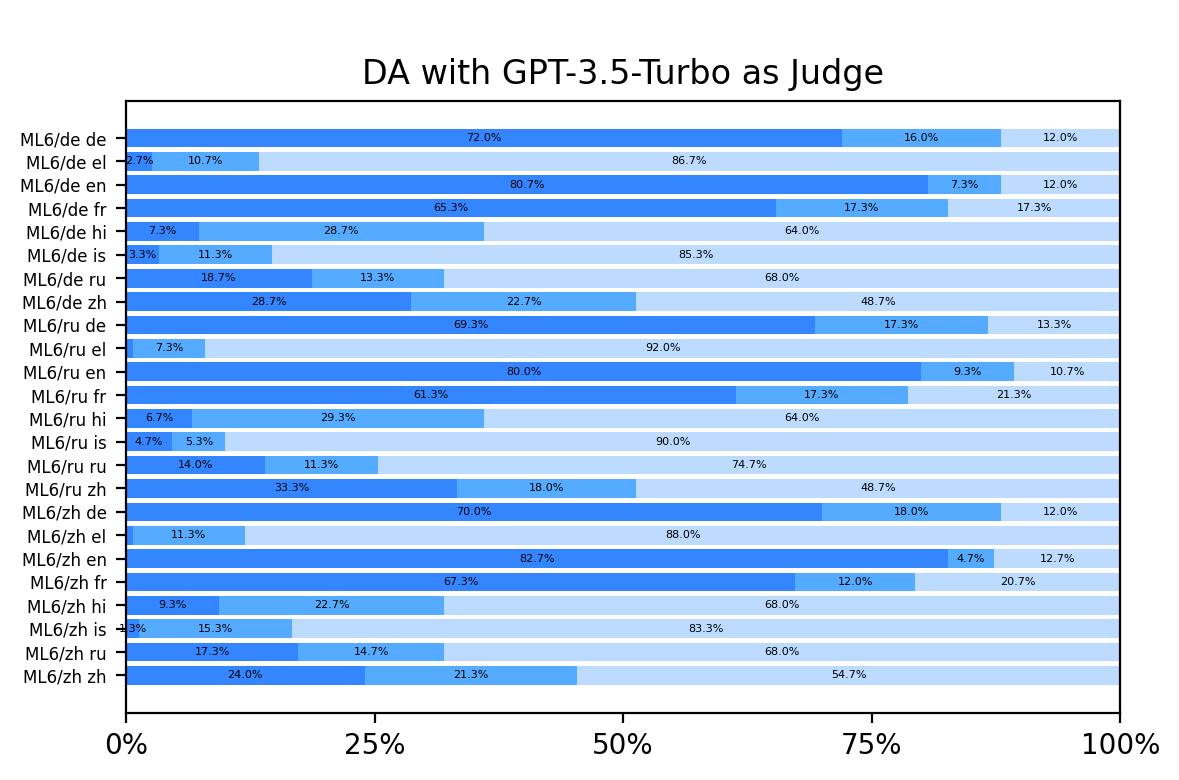

In [ ]:
def calculate_legend_bbox(subplot_height, figsize_height, margin_fraction=0.1):
    # Calculate the margin as a fraction of the subplot height
    margin = margin_fraction * subplot_height

    # Calculate the bbox_to_anchor value
    bbox_to_anchor = (0.5, -margin / figsize_height)

    return bbox_to_anchor

def calculate_figure_height(num_items, target_aspect_ratio):
    # Calculate the width of the figure based on the target aspect ratio
    fig_width = 6
    fig_height = fig_width / target_aspect_ratio

    # Calculate the subplot height based on the number of items
    subplot_height = fig_height / num_items

    return fig_width, fig_height, subplot_height

# plot the judgemtnts for each model
def plot_judgements(df, judge='GPT-3.5-Turbo', title=None, task_id='', output_dir=None, target_aspect_ratio=1.5, margin_fraction=0.5):
    """
    
    """
    
    # models = df['model_name'].unique().tolist()[::-1]
    test_sets = df['model_name_test_set'].unique().tolist()[::-1]

    # Calculate the figure width, height, and subplot height
    fig_width, fig_height, subplot_height = calculate_figure_height(len(test_sets), target_aspect_ratio=target_aspect_ratio)
    print(f'fig_width: {fig_width}, fig_height: {fig_height}, subplot_height: {subplot_height}')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_width, fig_height), sharey=True, sharex=True, dpi=200, tight_layout=True)

    colors = {'Excellent': '#0068FF', 'Pass': '#2B96FF', 'Fail': '#ABD2FF'}

    # for i, model in enumerate(models):
        # print(model)
    for j, test_set in enumerate(test_sets):
        # print(test_set)
        # sdf = df[(df['model_name'] == model) & (df['test_set'] == test_set)]
        sdf = df[df['model_name_test_set'] == test_set]
        # print(len(sdf))
        # print(sdf.columns)
        if judge == 'GPT-3.5-Turbo':
            results = sdf['gpt-3.5-turbo-judgement'].value_counts(normalize=True).to_dict()
        elif judge == 'GPT-4':
            results = sdf['gpt-4-judgement'].value_counts(normalize=True).to_dict()
        else:
            raise ValueError(f'Unknown judge: {judge}')
        
        # sort order: 'Excellent, Pass, Fail'
        results = {k: results.get(k, 0.0) for k in ['Excellent', 'Pass', 'Fail']}
        # multiply by 100 to get percentage
        results = {k: v * 100 for k, v in results.items()}

        print(f'{test_set}: {results}')

        prev_val = 0
        for k, v in results.items():

            ax.barh(y=j, width=v, height=0.8, left=prev_val, 
                    color=colors[k], alpha=0.8, # set the color of each bar individually
                    label=k if j == 0 else "", # label the first bar in each stack with the model name
                    )
            
            # label bar with value
            if v > 1:
                ax.text(x=prev_val + v/2, y=j, s=f'{v:.1f}%', ha='center', va='center', fontsize=4)

            # add the value of each bar to the previous value
            prev_val += v
    
            # # hide legend for all but the first model
            # if i == 0 and j > 0:
            #     ax.get_legend().remove()


    # Set the y-ticks to be the model names
    ax.set_yticks(np.arange(len(test_sets)), test_sets, fontsize=6)
    ax.set_xlabel('')

    ax.set_xticks([0, 25, 50, 75, 100], ['0%', '25%', '50%', '75%', '100%'], minor=False)
    # ax.set_xticklabels()

    # remove x-axis ticks
    # ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    # # put the legend out of the plot and center it
    # # if len(models) > 2:
    # bbox_to_anchor = calculate_legend_bbox(subplot_height, fig_height, margin_fraction=margin_fraction)
    # print(bbox_to_anchor)
    # ax.legend(bbox_to_anchor=bbox_to_anchor, loc='lower center', ncol=3, frameon=False)# , fontsize=8)
    # # else:
    # #     ax.legend(bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=3, frameon=False, fontsize=8)

    # Adjust the margins
    plt.margins(y=0.05, x=0.0)

    # title of plot
    if not title:
        ax.set_title(f'{task_id}\nDA with {judge} as Judge')
    else:
        ax.set_title(title)

    if output_dir is not None:
        outfile = Path(output_dir) / f'da_judge_{judge}-{task_id}.png'
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
        print(f'Saved to {outfile}')

    return

plot_judgements(gen_df, judge='GPT-3.5-Turbo')

fig_width: 6, fig_height: 4.0, subplot_height: 0.16666666666666666
ML6/zh zh: {'Excellent': 70.0, 'Pass': 8.0, 'Fail': 22.0}
ML6/zh ru: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh is: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh hi: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh fr: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh en: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh el: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh de: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru zh: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru ru: {'Excellent': 66.0, 'Pass': 6.0, 'Fail': 28.000000000000004}
ML6/ru is: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru hi: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru fr: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru en: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru el: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru de: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/de zh: {'Excell

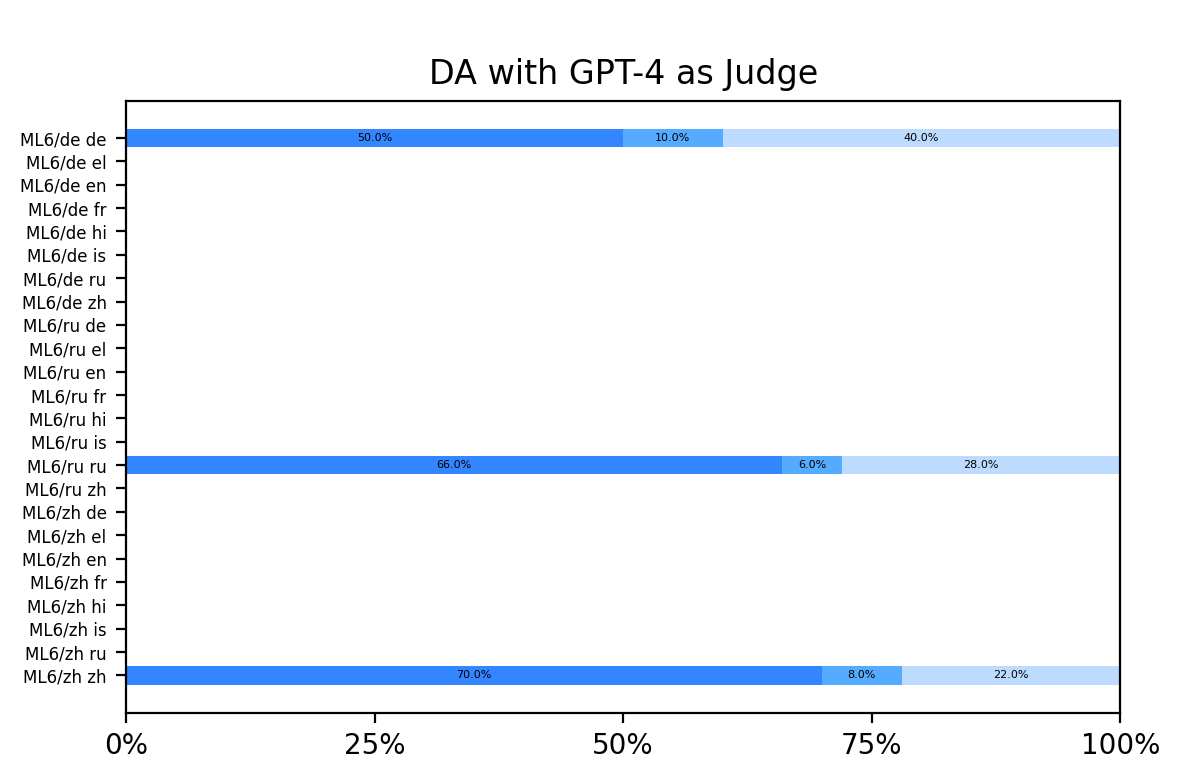

In [62]:
plot_judgements(gen_df, judge='GPT-4')


In [67]:
gen_df['gpt-4-justification'].value_counts()

gpt-4-justification
informative, interesting, correct                                                                                                                                                                                                                                   42
informative, interesting, and correct                                                                                                                                                                                                                               20
incorrect information                                                                                                                                                                                                                                                5
informative, correct, and detailed                                                                                                                                                             

In [68]:
gen_df['gpt-3.5-turbo-justification'].value_counts()

gpt-3.5-turbo-justification
language                                                                                                                                                                                                 1810
informative, interesting                                                                                                                                                                                 1112
grammatical, sufficient                                                                                                                                                                                   263
grammatical, informative                                                                                                                                                                                   92
grammatical                                                                                                                                         

In [14]:
# inspect off-target generations in output files

def get_generations(results_dir):
    dfs = []
    for generations_file in Path(results_dir).glob('*/*.jsonl'):
        # print(eval_file)
        df = pd.read_json(generations_file, lines=True)
        model_name, test_set, prompt, seed = parse_filename(generations_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
    df = pd.concat(dfs, axis=0, ignore_index=False)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    # cols.insert(0, df.ndex)
    df = df.reindex(columns=cols)

    return df

gen_df = get_generations(results_dir)
gen_df

,model_name,test_set,seed,prompt,system,finish_reason,source,secs,source_lang,system_lang,context
0,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie lauten die Namen einiger berüh...",Here are some famous actors who began their ca...,stop,"""Wie lauten die Namen einiger berühmter Schaus...",2.562441,deu_Latn,eng_Latn,guanaco_prompt
1,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie haben die US-Bundesstaaten ihr...",Die Staaten der Vereinigten Staaten von Amerik...,length,"""Wie haben die US-Bundesstaaten ihre Namen erh...",2.562441,deu_Latn,deu_Latn,guanaco_prompt
2,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Hallo, meine Schwester und ihre Fr...",Sure! Kickball is a game that combines element...,stop,"""Hallo, meine Schwester und ihre Freundinnen m...",2.562441,deu_Latn,eng_Latn,guanaco_prompt
3,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Was sind einige coole Musikstücke ...","""Die 20er Jahre waren eine Zeit des wirtschaft...",stop,"""Was sind einige coole Musikstücke aus den 192...",2.562441,deu_Latn,deu_Latn,guanaco_prompt
4,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie verpacke ich ein Geschenk orde...","""Ein Geschenk verpacken ist eine wichtige Sach...",stop,"""Wie verpacke ich ein Geschenk ordentlich?""",2.562441,deu_Latn,deu_Latn,guanaco_prompt
...,...,...,...,...,...,...,...,...,...,...,...
800,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一段YouTube视频撰写剧本，探索爵士乐的历史和文化意义。### ...,"[推荐视频]\n\n<iframe width=""560"" height=""315"" src...",stop,为一段YouTube视频撰写剧本，探索爵士乐的历史和文化意义。,3.112936,NaN,NaN,guanaco_prompt
801,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 撰写一篇有趣的旅行博客文章，介绍最近去夏威夷的旅行，重点突出文化体验和...,![](https://cdn-images-1.medium.com/max/1600/1...,stop,撰写一篇有趣的旅行博客文章，介绍最近去夏威夷的旅行，重点突出文化体验和必看景点。,3.112936,NaN,NaN,guanaco_prompt
802,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一部最近上映的科幻电影撰写一个引人入胜的影评，讨论其剧情、角色和特效...,电影《黑洞之魂》简介\n\n《黑洞之魂》是一部2021年上映的科幻电影，由迈克尔·杰克逊导演...,stop,为一部最近上映的科幻电影撰写一个引人入胜的影评，讨论其剧情、角色和特效。,3.112936,NaN,NaN,guanaco_prompt
803,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一集讨论流媒体平台对音乐产业影响的播客脚本进行构建。### Assi...,[一句话简介]\n\n我们将讨论流媒体平台对音乐产业的影响，并对此进行探讨。我们将从三个角度...,stop,为一集讨论流媒体平台对音乐产业影响的播客脚本进行构建。,3.112936,NaN,NaN,guanaco_prompt


In [15]:
# def inspect_longer_strings(text):
#     # escape newlines
#     text = text.replace('\n', '\\n')
#     text_ = text[:100]
#     if len(text) > len(text_):
#         text_ += '...'
#     return text_

# for i, row in gen_df.iterrows():
#     expected_lang = row['test_set'][-2:]
#     # print(expected_lang)
#     if row['system_lang'] != expected_lang:
#         print(i, inspect_longer_strings(row['source']))
#         print(row['system_lang'], inspect_longer_strings(row['system']))
#         print('*****')
#         # break

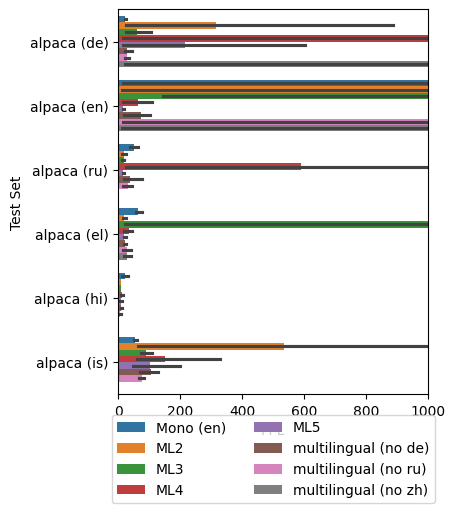

In [16]:
# plot bar plots of lang_match

fig, ax = plt.subplots(figsize=(4, 5))

sns.barplot(x='ppl', y='test_set', hue='model_name', errorbar='ci', orient='h', data=df, ax=ax)

ax.set_xlabel('PPL')
ax.set_ylabel('Test Set')

ax.set_xlim(0, 1000)
# legend at bottom
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)



In [ ]:
# # sort models given the order in name_map
# model_names = df['model_name'].unique()
# ordered_model_names = sorted(model_names, key=lambda x: list(name_map.values()).index(x))
# print(ordered_model_names)
# ordered_test_sets = sorted(df['test_set'].unique())
# print(ordered_test_sets)
# ordered_seeds = sorted(df['seed'].unique())
# print(ordered_seeds)

# def apply_sort(df):

#     df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)

#     df['context'] = pd.Categorical(df['context'], ordered_contexts)

#     df = df.sort_values(by=['test_set', 'model_name', 'context', 'seed'])

#     # Convert the columns back to their original data types
#     df['model_name'] = df['model_name'].astype(str)
#     df['context'] = df['context'].astype(str)
        
#     df = df.reset_index(drop=True)

#     return df

# # drop columns containing any NaN values
# # df = df.dropna(axis=1, how='any')

# # sort dataframe
# df = apply_sort(df)

# # store sort order
# custom_sort_index = df.index.tolist()
# df['idx'] = custom_sort_index
# print(df.columns)
# df.head(4)